<a href="https://colab.research.google.com/github/dlevonian/EmotionX-2019/blob/master/emotionx_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EmotionX 2019

[EmotionX 2019 Challenge](https://sites.google.com/view/emotionx2019/home?authuser=0)

Participants are challenged to predict the emotions induced by dialogue utterances by classifying each utterance into one of four label candidates: joy, sadness, anger, and neutral.

Leaderboard for the Friends dataset:

![alt text](https://drive.google.com/uc?id=1wWCGTD-rFySYK350_QQyEdXdDAzMKQ1d)

Thanks to David Patton for this great notebook:
https://github.com/dcpatton/NLP/blob/master/Friends_Albert.ipynb

Thanks to George Zoto, David Patton, and Robert Kraig for organizing the [Deep Learning Adventures](https://www.meetup.com/Deep-Learning-Adventures/) group

### Imports

In [ ]:
# make sure nightly builds are installed to use official.nlp modules
# this is needed for BERT tokenization and, optionally, for custom official.nlp optimizers
!pip install tf-nightly
!pip install -q tf-models-nightly

In [2]:
import numpy as np
import pandas as pd

import math
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
# %load_ext tensorboard

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.tokenization as tokenization
import official.nlp.optimization as optimization

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.preprocessing import LabelEncoder

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print('GPU is available' if tf.config.experimental.list_physical_devices('GPU') else 'CPU')

TF version:  2.4.0-dev20200813
Hub version:  0.8.0
GPU is available


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/EmotionX_2019/'

Mounted at /content/drive


In [6]:
seed_value=2020
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Load EmotionX 2019

In [7]:
train_original = pd.read_json(path+'emotionx_data/2019_Train_Friends/Friends/friends.json')
print(train_original.shape)
train_original.head(2)

(1000, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,"{'speaker': 'Phoebe', 'utterance': 'Oh my God,...","{'speaker': 'Monica', 'utterance': 'What?', 'e...","{'speaker': 'Ross', 'utterance': 'Or! Or, we c...","{'speaker': 'Chandler', 'utterance': 'Youre a...","{'speaker': 'Joey', 'utterance': 'Aww, man, no...","{'speaker': 'Chandler', 'utterance': 'Now, the...","{'speaker': 'Phoebe', 'utterance': 'Hey.', 'em...","{'speaker': 'All', 'utterance': 'Hey!', 'emoti...","{'speaker': 'Phoebe', 'utterance': 'Ohh, you g...","{'speaker': 'Rachel', 'utterance': 'Where?!', ...","{'speaker': 'Phoebe', 'utterance': 'On the tou...","{'speaker': 'Ross', 'utterance': 'And', 'emoti...","{'speaker': 'Phoebe', 'utterance': 'No, I know...","{'speaker': 'Phoebe', 'utterance': 'I-Im sorr...","{'speaker': 'Monica', 'utterance': 'Well, next...","{'speaker': 'Joey', 'utterance': 'Yeah! Yeah! ...","{'speaker': 'Chandler', 'utterance': 'Thank yo...","{'speaker': 'Joey', 'utterance': 'No-no, thank...",None,None,None,None,None,None
1,"{'speaker': 'Joey', 'utterance': 'Hey Estelle,...","{'speaker': 'Estelle', 'utterance': 'Well! Wel...","{'speaker': 'Joey', 'utterance': 'What are you...","{'speaker': 'Estelle', 'utterance': 'Really?!'...","{'speaker': 'Joey', 'utterance': 'Yeah!', 'emo...","{'speaker': 'Estelle', 'utterance': 'Oh well, ...","{'speaker': 'Gary', 'utterance': 'Okay, you gu...","{'speaker': 'Ross', 'utterance': 'Yeah!!', 'em...","{'speaker': 'Chandler', 'utterance': 'Tonight?...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [8]:
# augmented data (round-trip translation)
train_augmented = pd.read_json(path+'emotionx_data/2019_Train_Friends/Friends/friends.augmented.json')
print(train_augmented.shape)
train_augmented.sample(2)

(1000, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
725,"{'speaker': 'Monica', 'utterance': 'Hey! What ...","{'speaker': 'Joey', 'utterance': 'I don't know...","{'speaker': 'Joey', 'utterance': 'It's not lik...","{'speaker': 'Joey', 'utterance': 'This is a se...","{'speaker': 'Joey', 'utterance': 'Y'know?', 'e...","{'speaker': 'Joey', 'utterance': 'And the nudi...","{'speaker': 'Monica', 'utterance': 'That's wha...","{'speaker': 'Joey', 'utterance': 'You're right...","{'speaker': 'Monica', 'utterance': 'No! No you...","{'speaker': 'Joey', 'utterance': 'Well that's ...","{'speaker': 'Joey', 'utterance': 'And I am onl...","{'speaker': 'Joey', 'utterance': 'Plus it soun...","{'speaker': 'Joey', 'utterance': 'My character...","{'speaker': 'Joey', 'utterance': 'Who run away...","{'speaker': 'Joey', 'utterance': 'So we go int...","{'speaker': 'Joey', 'utterance': 'It's really ...",None,None,None,None,None,None,None,None
986,"{'speaker': 'Chandler', 'utterance': 'How abou...","{'speaker': 'Joey', 'utterance': 'No, still to...","{'speaker': 'Chandler', 'utterance': 'Joey... ...","{'speaker': 'Joey', 'utterance': 'Plus, y'know...","{'speaker': 'Joey', 'utterance': 'Y'know, Joey...","{'speaker': 'Joey', 'utterance': 'Which I'm no...","{'speaker': 'Chandler', 'utterance': 'Joe...Jo...","{'speaker': 'Joey', 'utterance': 'Stalin...Sta...","{'speaker': 'Chandler', 'utterance': 'Well, it...","{'speaker': 'Joey', 'utterance': 'Joe Stalin. ...","{'speaker': 'Chandler', 'utterance': 'Might wa...","{'speaker': 'Joey', 'utterance': 'Joseph Stali...","{'speaker': 'Chandler', 'utterance': 'Oh yes! ...",None,None,None,None,None,None,None,None,None,None,None


In [9]:
# concatenate the regular and augmented
train_df = pd.concat([train_original, train_augmented], axis=0)
train_df.index = range(len(train_df))
train_df.shape

(2000, 24)

In [10]:
test_df = pd.read_json(path+'emotionx_data/2019_Eval_Labeled/friends_eval_gold.json')
print(test_df.shape)
test_df.sample(2)

(240, 24)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
99,"{'speaker': 'Chandler', 'utterance': 'Did she ...","{'speaker': 'Phoebe', 'utterance': 'No, sorry....","{'speaker': 'Chandler', 'utterance': 'All righ...","{'speaker': 'Joey', 'utterance': 'No! Forget h...","{'speaker': 'Ross', 'utterance': 'Hes right, ...","{'speaker': 'Chandler', 'utterance': 'Well, ye...","{'speaker': 'Ross', 'utterance': 'How might yo...","{'speaker': 'Chandler', 'utterance': 'Well y'k...","{'speaker': 'Joey', 'utterance': 'Dude, tell m...","{'speaker': 'Chandler', 'utterance': 'She did ...","{'speaker': 'Ross', 'utterance': 'Thats all y...","{'speaker': 'Chandler', 'utterance': 'Thats n...","{'speaker': 'Joey', 'utterance': 'Whoa-whoa, t...","{'speaker': 'Chandler', 'utterance': 'Oh my Go...",None,None,None,None,None,None,None,None,None,None
26,"{'speaker': 'Joey', 'utterance': 'So thats wh...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Exactly.', '...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Or, I could ...","{'speaker': 'Casting Director #2', 'utterance'...","{'speaker': 'Joey', 'utterance': 'Yeah, okay.'...",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [11]:
def flatten_dialogs(df):
    speaker, utterance, preceding, emotion  = [], [], [], []
    for r, row in df.iterrows():
        for i in range(len(df.columns)):
            if row[i] is not None:
                speaker.append(row[i]['speaker'])
                emotion.append(row[i]['emotion'])
                utterance.append(row[i]['utterance'].replace('\x92', '`'))
                preceding.append('Start of the dialog:') if i==0 else preceding.append(utterance[-2])

    return pd.DataFrame(zip(speaker, preceding, utterance, emotion), 
                        columns =['speaker', 'preceding', 'utterance', 'emotion'])    

In [12]:
train_df = flatten_dialogs(train_df)
train_df.head()

,speaker,preceding,utterance,emotion
0,Phoebe,Start of the dialog:,"Oh my God, he`s lost it. He`s totally lost it.",non-neutral
1,Monica,"Oh my God, he`s lost it. He`s totally lost it.",What?,surprise
2,Ross,What?,"Or! Or, we could go to the bank, close our acc...",neutral
3,Chandler,"Or! Or, we could go to the bank, close our acc...",You`re a genius!,joy
4,Joey,You`re a genius!,"Aww, man, now we won`t be bank buddies!",sadness


In [13]:
test_df = flatten_dialogs(test_df)
test_df.head()

,speaker,preceding,utterance,emotion
0,Phoebe,Start of the dialog:,"Alright, whadyou do with him?",non-neutral
1,Monica,"Alright, whadyou do with him?",Oh! You're awake!,surprise
2,Joey,Oh! You're awake!,Then you gotta come clean with Ma! This is not...,anger
3,Mr. Tribbiani,Then you gotta come clean with Ma! This is not...,"Yeah, but this is",neutral
4,Joey,"Yeah, but this is",I don't wanna hear it! Now go to my room!,anger


In [14]:
print(train_df.shape)
print(test_df.shape)

(29006, 4)
(3296, 4)


### Process train/test

In [15]:
# There are more speakers than the main 6 characters:
print(len(train_df.speaker.unique()))
train_df.speaker.unique()[:30]

309


array(['Phoebe', 'Monica', 'Ross', 'Chandler', 'Joey', 'All', 'Rachel',
       'Estelle', 'Gary', 'Guy', 'Woman', 'Mrs. Green', 'Dr. Harad',
       'Frank', 'Alice', 'Bob', 'Whitney', 'Kyle', 'Passerby', 'Susan',
       'Cookie', 'Kori', 'Dr. Long', 'Carol', 'Mark', 'TV Announcer',
       'The Hot Girl', 'Jen', 'Monica and Rachel', 'The Dry Cleaner'],
      dtype=object)

In [16]:
main_characters = train_df.speaker.value_counts()[:6].index.tolist()
print(main_characters)

['Ross', 'Joey', 'Rachel', 'Phoebe', 'Monica', 'Chandler']


In [17]:
# Label all non-main speakers as 'Other'
train_df.speaker = train_df.speaker.apply(lambda x: x if x in main_characters else 'Other')
test_df.speaker = test_df.speaker.apply(lambda x: x if x in main_characters else 'Other')

train_df.speaker.value_counts()

Other       4808
Ross        4332
Joey        4326
Rachel      4190
Phoebe      3852
Monica      3776
Chandler    3722
Name: speaker, dtype: int64

Explore the distribution of emotions:

In [18]:
speaker_emotions = train_df.groupby(['speaker', 'emotion']).count().reset_index()
speaker_emotions = speaker_emotions.pivot_table(index='speaker', columns='emotion', values='utterance', 
                                                aggfunc=np.sum, margins=True)
speaker_emotions

emotion,anger,disgust,fear,joy,neutral,non-neutral,sadness,surprise,All
speaker,,,,,,,,,
Chandler,122,102,90,398,1742,772,92,404,3722
Joey,214,90,70,550,1960,816,120,506,4326
Monica,208,132,48,452,1568,790,96,482,3776
Other,246,70,78,572,2470,718,172,482,4808
Phoebe,228,94,60,464,1664,734,150,458,3852
Rachel,252,86,64,506,1644,872,198,568,4190
Ross,248,88,82,478,2012,842,168,414,4332
All,1518,662,492,3420,13060,5544,996,3314,29006


In [19]:
speaker_emotions = speaker_emotions.sort_values(by ='All', axis=1, ascending =False)
speaker_emotions = speaker_emotions.apply(lambda row: row/row[0], axis=1).drop('All', axis=1)
speaker_emotions

emotion,neutral,non-neutral,joy,surprise,anger,sadness,disgust,fear
speaker,,,,,,,,
Chandler,0.468028,0.207415,0.106932,0.108544,0.032778,0.024718,0.027405,0.024181
Joey,0.453074,0.188627,0.127138,0.116967,0.049468,0.027739,0.020804,0.016181
Monica,0.415254,0.209216,0.119703,0.127648,0.055085,0.025424,0.034958,0.012712
Other,0.513727,0.149334,0.118968,0.100250,0.051165,0.035774,0.014559,0.016223
Phoebe,0.431983,0.190550,0.120457,0.118899,0.059190,0.038941,0.024403,0.015576
Rachel,0.392363,0.208115,0.120764,0.135561,0.060143,0.047255,0.020525,0.015274
Ross,0.464451,0.194367,0.110342,0.095568,0.057248,0.038781,0.020314,0.018929
All,0.450252,0.191133,0.117907,0.114252,0.052334,0.034338,0.022823,0.016962


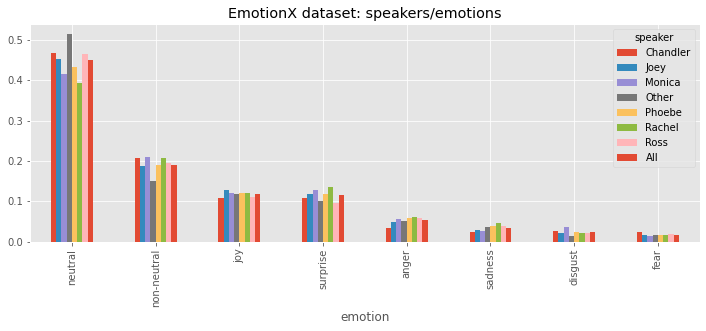

In [20]:
speaker_emotions.T.plot(kind='bar', figsize=(12, 4), title='EmotionX dataset: speakers/emotions');

#observation: emotions are relatively evenly spread among the speakers

In [21]:
# In EmotionX_2019, all 7 emotions are tagged but only 4 categories are counted towards the competition f1 metric:
# Neutral, Joy, Anger, Sadness
# 'Surprise', the second-largest distinct category, is not included (?)

allowed_emotions = ['neutral', 'joy', 'anger', 'sadness']
train_df = train_df[train_df.emotion.isin(allowed_emotions)]
test_df = test_df[test_df.emotion.isin(allowed_emotions)]

In [22]:
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['emotion'].values)
test_df['label']  = labelEncoder.transform(test_df['emotion'].values)
train_df.head()

,speaker,preceding,utterance,emotion,label
2,Ross,What?,"Or! Or, we could go to the bank, close our acc...",neutral,2
3,Chandler,"Or! Or, we could go to the bank, close our acc...",You`re a genius!,joy,1
4,Joey,You`re a genius!,"Aww, man, now we won`t be bank buddies!",sadness,3
5,Chandler,"Aww, man, now we won`t be bank buddies!","Now, there`s two reasons.",neutral,2
6,Phoebe,"Now, there`s two reasons.",Hey.,neutral,2


In [23]:
EMOTION_NAMES = labelEncoder.classes_
NUM_EMOTIONS = len(EMOTION_NAMES)
EMOTION_NAMES

array(['anger', 'joy', 'neutral', 'sadness'], dtype=object)

In [24]:
# encode the speakers
speakerEncoder = LabelEncoder()
train_df['s'] = speakerEncoder.fit_transform(train_df['speaker'].values)
test_df['s'] = speakerEncoder.transform(test_df['speaker'].values)
train_df.head()

,speaker,preceding,utterance,emotion,label,s
2,Ross,What?,"Or! Or, we could go to the bank, close our acc...",neutral,2,6
3,Chandler,"Or! Or, we could go to the bank, close our acc...",You`re a genius!,joy,1,0
4,Joey,You`re a genius!,"Aww, man, now we won`t be bank buddies!",sadness,3,1
5,Chandler,"Aww, man, now we won`t be bank buddies!","Now, there`s two reasons.",neutral,2,0
6,Phoebe,"Now, there`s two reasons.",Hey.,neutral,2,4


In [25]:
SPEAKER_NAMES = speakerEncoder.classes_
NUM_SPEAKERS = len(SPEAKER_NAMES)
SPEAKER_NAMES

array(['Chandler', 'Joey', 'Monica', 'Other', 'Phoebe', 'Rachel', 'Ross'],
      dtype=object)

In [26]:
# y_true to be used in performance metrics
y_true = test_df.label

# reindex
train_df.index = range(len(train_df))
test_df.index = range(len(test_df))
print(train_df.shape)
print(test_df.shape)

(18994, 6)
(1802, 6)


### Random f1

In [27]:
# scores_df to keep track of performace. Initialize with top-3 teams from EmotionX 2019 challenge
scores_df = pd.DataFrame(data={
                            'team/model': ['NTHU IDEA Lab --2019', 'KAKAO NLP+KU  --2019', 'HSU HK --2019'],
                            'micro-f1': [81.5, 79.5, 79.1],
                            'macro-f1': [73.1, 68.7, 69.9]
                            })

def update_scores(scores_df, model_name, y_pred, y_true=y_true, target_names=EMOTION_NAMES):

    report = classification_report(y_true, y_pred, target_names=target_names, digits=3)
    print(report)
    
    # f1 scores are contained at specific points in sklearn class.report string
    micro = 100*float(report.split('accuracy')[1][25:35])  
    macro = 100*float(report.split('macro avg')[1][25:35])
    scores_df.loc[scores_df.shape[0]]=[model_name, micro, macro]

    return scores_df

2 types of random benchmark:
- stratified, i.e. random shuffle preserving class weights
- majority class

In [28]:
# Stratified random shuffle
y_shuffled = y_true.copy().values
np.random.shuffle(y_shuffled)

scores_df = update_scores(scores_df, 'random stratified', y_shuffled)
scores_df.head(10)

              precision    recall  f1-score   support

       anger      0.092     0.092     0.092       141
         joy      0.297     0.297     0.297       505
     neutral      0.574     0.574     0.574      1035
     sadness      0.066     0.066     0.066       121

    accuracy                          0.425      1802
   macro avg      0.257     0.257     0.257      1802
weighted avg      0.425     0.425     0.425      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7


In [29]:
# predict all y_pred as majority class
maj_class = y_true.value_counts().index[0]
maj_pred = np.full_like(y_true, maj_class)
print(maj_class, EMOTION_NAMES[maj_class])

scores_df = update_scores(scores_df, 'all majority class', maj_pred)
scores_df.head(10)

2 neutral
              precision    recall  f1-score   support

       anger      0.000     0.000     0.000       141
         joy      0.000     0.000     0.000       505
     neutral      0.574     1.000     0.730      1035
     sadness      0.000     0.000     0.000       121

    accuracy                          0.574      1802
   macro avg      0.144     0.250     0.182      1802
weighted avg      0.330     0.574     0.419      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7
4,all majority class,57.4,18.2


### Load BERT, encode

In [30]:
tic = time.time()

# Import the smaller, uncased version of BERT, 109 M parameters, 387 MB size
# L=12 Transformer blocks, H=768 hidden size, A=12 attention heads.
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",  
                            name = 'bert_layer',
                            trainable=True)
toc = time.time()
print(f'done in {toc-tic:.1f} sec')

done in 12.0 sec


In [31]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
# dir(tokenizer)

In [32]:
tokens = tokenizer.tokenize(train_df.utterance[0])
ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(ids)

['or', '!', 'or', ',', 'we', 'could', 'go', 'to', 'the', 'bank', ',', 'close', 'our', 'accounts', 'and', 'cut', 'them', 'off', 'at', 'the', 'source', '.']
[2030, 999, 2030, 1010, 2057, 2071, 2175, 2000, 1996, 2924, 1010, 2485, 2256, 6115, 1998, 3013, 2068, 2125, 2012, 1996, 3120, 1012]


In [33]:
def encode_sentence(s, first=True):
    # the first sentence in BERT must start with [CLS] token and end with [SEP]
    # the second sentence is optional. if supplied as input to BERT, append to the first sentence
    if first:
        return (tokenizer.convert_tokens_to_ids(['[CLS]']) + 
                tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s)) + 
                tokenizer.convert_tokens_to_ids(['[SEP]']))
    else:
        return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(s))

# MAX_LEN based on the longer uu
train_ids = train_df.utterance.apply(encode_sentence)
test_ids = test_df.utterance.apply(encode_sentence)

In [34]:
max_len_train = max(map(len, train_ids))
max_len_test = max(map(len, test_ids))
MAX_LEN = max(max_len_train, max_len_test)

print(f'max len train =', max_len_train)
print(f'max len test =', max_len_test)
print(f'MAX LEN =', MAX_LEN)

max len train = 65
max len test = 67
MAX LEN = 67


In [35]:
z = train_df['utterance'].apply(lambda x: encode_sentence(x, False)).values


In [36]:
train_ids[:2].values

array([list([101, 2030, 999, 2030, 1010, 2057, 2071, 2175, 2000, 1996, 2924, 1010, 2485, 2256, 6115, 1998, 3013, 2068, 2125, 2012, 1996, 3120, 1012, 102]),
       list([101, 2017, 1036, 2128, 1037, 11067, 999, 102])], dtype=object)

In [37]:
print(z.shape)


(18994,)


In [38]:
    zz = pad_sequences(z, maxlen=MAX_LEN, dtype="long", value=0, padding="post")

In [39]:
aa = zz
dd = np.concatenate([aa,zz], axis=1)
print(zz.shape, dd.shape)

(18994, 67) (18994, 134)


### TF Dataset

In [40]:
train_df.sample(5)

,speaker,preceding,utterance,emotion,label,s
14922,Joey,They loved me!,Oh my God!,joy,1,1
4057,Joey,"Y`know you wear a white coat, I wear a blue bl...","Y`know, hey I understand.",neutral,2,1
17510,Ross,Ezel! Hey Gunther! You're an ezel!,Damnit!,anger,0,6
2182,Joey,Yeah.,Monica and Rachel made out.,neutral,2,1
15980,Chandler,Dude!,And hats off to Phoebe. Quite a competitor. A...,joy,1,0


In [41]:
BATCH_SIZE=32

def bert_dataset(df,
                 maxlen=MAX_LEN, 
                 two_utt=False,
                 include_speakers=False,
                 num_speakers=NUM_SPEAKERS,
                 num_emotions=NUM_EMOTIONS,
                 split=0.9,
                 shuffle=True,
                 batch_size=BATCH_SIZE,                  
                 ):
    """
    Produce TF datasets, both train and val, from the input dataframe
    The convention for the input df: 
        labels        in column 'label,
        utterances    in column 'utterance'
        preceding utt in column 'preceding'
        speaker codes in column 's'
    """
    # single input utterance
    input_utt  = df['utterance'].apply(lambda x: encode_sentence(x)).values
    input_utt = pad_sequences(input_utt, maxlen=maxlen, dtype="long", value=0, padding="post")

    # for two utterances incl. preceding, concatenate two np.arrays (note preceding seq len=MAX_LEN-2)
    if two_utt:
        preceding = df['preceding'].apply(lambda x: encode_sentence(x, first=False)).values    
        preceding = pad_sequences(preceding, maxlen=maxlen-2, dtype="long", value=0, padding="post")
        input_utt = np.concatenate([input_utt, preceding], axis=1)

    input_mask = np.vectorize(lambda arr: int(arr>0))(input_utt)

    # BERT needs the segment embedding input: 0s for 1st segment, 1s for the 2nd segment (after [SEP])
    input_segment = np.zeros_like(input_mask)
    if two_utt:
        input_segment[:,maxlen:]=1

    # add speakers to X tensor
    if not include_speakers:
        inputs = (input_utt, input_mask, input_segment)
    else:
        speakers = to_categorical(df['s'].values, num_classes=num_speakers)
        inputs = (input_utt, input_mask, input_segment, speakers)
    
    # one-hot encode the labels (Y)
    labels = to_categorical(df['label'].values, num_classes=num_emotions)

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    if shuffle: dataset = dataset.shuffle(1024)
    
    split = int(split*df.shape[0])
    train_ds = dataset.take(split).batch(batch_size).cache()
    val_ds   = dataset.skip(split).batch(batch_size).cache()
    
    return train_ds, val_ds


In [42]:
train_ds, val_ds = bert_dataset(train_df, two_utt=True, include_speakers=True)
# train_ds, val_ds = bert_dataset(train_df, include_speakers=True)

# inspect the dataset element
print(train_ds.element_spec )
next(iter(train_ds))


((TensorSpec(shape=(None, 132), dtype=tf.int64, name=None), TensorSpec(shape=(None, 132), dtype=tf.int64, name=None), TensorSpec(shape=(None, 132), dtype=tf.int64, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


((<tf.Tensor: shape=(32, 132), dtype=int64, numpy=
  array([[ 101, 2054, 1036, ...,    0,    0,    0],
         [ 101, 2298, 1010, ...,    0,    0,    0],
         [ 101, 4931, 6887, ...,    0,    0,    0],
         ...,
         [ 101, 4931,  999, ...,    0,    0,    0],
         [ 101,  999,  102, ...,    0,    0,    0],
         [ 101, 2821, 2057, ...,    0,    0,    0]])>,
  <tf.Tensor: shape=(32, 132), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]])>,
  <tf.Tensor: shape=(32, 132), dtype=int64, numpy=
  array([[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]])>,
  <tf.Tensor: shape=(32, 7), dtype=float32, numpy=
  array([[0., 0., 1., 0.,

### BERT model

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.initializers import Constant

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

from tensorflow.keras import callbacks
import tensorflow.keras.backend as K


In [44]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(NUM_EMOTIONS, average='micro', name='f1')   # the competition metric

In [45]:
# (input_utt, input_mask, input_segment, speakers)

def bert_model( max_len=MAX_LEN, 
                two_utt=False,
                num_emotions=NUM_EMOTIONS,
                include_speakers=False,
                num_speakers=NUM_SPEAKERS,
                dropout_rate=0, 
                seed=seed_value):
    
    if two_utt:   # encoded as: [CLS] + utterance_1 + [SEP] + utterance_2
        max_len = 2*max_len - 2

    input_utt = Input(shape=(max_len,), dtype=tf.int32, name="input_utt")
    input_mask     = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_segment    = Input(shape=(max_len,), dtype=tf.int32, name="input_segment")

    # deep copy of a keras layer object is problematic, therefore download for each instance
    bert = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",  
                                name = 'bert_layer', trainable=True)

    if not include_speakers:
        inputs = [input_utt, input_mask, input_segment]
        x, _ = bert(inputs)
        x = Dropout(dropout_rate, seed=seed, name='dropout')(x)
    else:
        speakers = Input(shape=(num_speakers,), dtype=tf.float32, name="speakers")
        inputs = [input_utt, input_mask, input_segment, speakers]
        x, _ = bert(inputs[:-1])
        x = Dropout(dropout_rate, seed=seed, name='dropout')(x)
        x = tf.concat([x, speakers], axis=1)
        x = Dense(512, activation='relu')(x)

    output = Dense(num_emotions, activation='softmax')(x)
    model = Model(inputs, output)

    return model


In [46]:
def plot_training(history):

    f,axes = plt.subplots(1, 2, figsize=(12, 4))
    ax0,ax1=axes[0],axes[1]
    
    hist = history.history
    epochs = np.arange(1,1+len(hist['loss']))

    ax0.plot(epochs, hist['f1'], label='f1 train') 
    ax0.plot(epochs, hist['val_f1'], label='f1 val') 
    ax0.set_title('f1 score')
    ax0.legend()

    ax1.plot(epochs, hist['P'], label='precision train') 
    ax1.plot(epochs, hist['R'], label='recall train') 
    ax1.plot(epochs, hist['val_P'], label='precision val') 
    ax1.plot(epochs, hist['val_R'], label='recall val') 
    ax1.set_title('precision / recall')
    ax1.legend()

    plt.show()

In [47]:
# test model
model = bert_model(two_utt=True, include_speakers=True)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_utt (InputLayer)          [(None, 132)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 132)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 132)]        0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_utt[0][0]                  
                                                                 input_mask[0][0]      

In [48]:
# Test the computational graph
tic=time.time()
sample_input = next(iter(train_ds))

# Dataset is a generator of (X,Y). Only X should be passed to the model, i.e. sample_input[0]
sample_output = model(sample_input[0])

toc=time.time()
print(f'done in {toc-tic:.1f} sec')
print(sample_output.shape)


done in 2.1 sec
(32, 4)


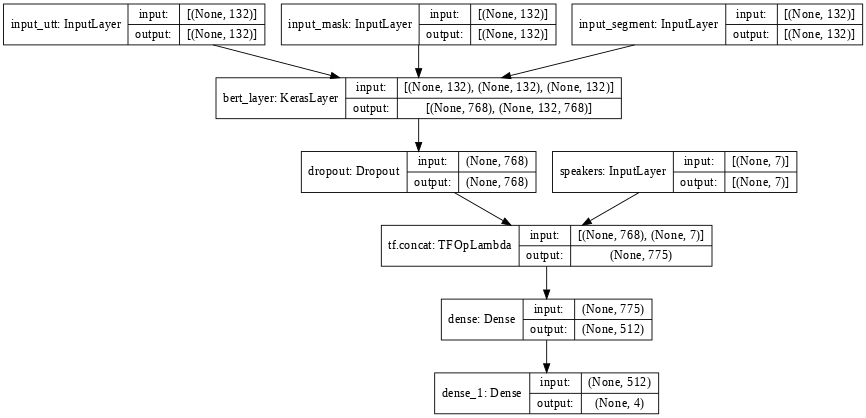

In [49]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [50]:
def run_model(config):
    
    train_ds, val_ds = bert_dataset(train_df, **config)
    test_ds, _ = bert_dataset(test_df,  **config, split=1, shuffle=False)
    model = bert_model(**config)
    
    EPOCHS=10
    LR=1e-5

    model.compile(optimizer=Adam(LR),
                  loss=CategoricalCrossentropy(),
                  metrics=[f1_score, Precision(name='P'), Recall(name='R')])

    def scheduler(epoch, lr):
        # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
        flat_period, decay, floor_lr = 5, -0.2, 1e-6
        if epoch<=flat_period: 
            return lr
        return max(lr*np.exp(decay), floor_lr)
   
    lr_callback=callbacks.LearningRateScheduler(scheduler, verbose=1) 
    es_callback=callbacks.EarlyStopping(monitor='val_f1', verbose=1, patience=2, mode='max')

    history=model.fit(train_ds,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[lr_callback, es_callback],
                    validation_data=val_ds)
    plot_training(history)

    y_pred = model.predict(test_ds).argmax(axis=1)
     
    return y_pred 


### m0. single utt


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 161s 302ms/step - loss: 0.6624 - f1: 0.7828 - P: 0.8141 - R: 0.7444 - val_loss: 0.3956 - val_f1: 0.8616 - val_P: 0.8766 - val_R: 0.8411

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 145s 272ms/step - loss: 0.3769 - f1: 0.8739 - P: 0.8882 - R: 0.8586 - val_loss: 0.2707 - val_f1: 0.9011 - val_P: 0.9125 - val_R: 0.8942

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/10
535/535 [==============================] - 145s 272ms/step - loss: 0.2424 - f1: 0.9210 - P: 0.9276 - R: 0.9137 - val_loss: 0.1702 - val_f1: 0.9432 - val_P: 0.9454 - val_R: 0.9395

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
535/535 [==============================] - 145s 271ms/step - loss: 0.1492 - f1:

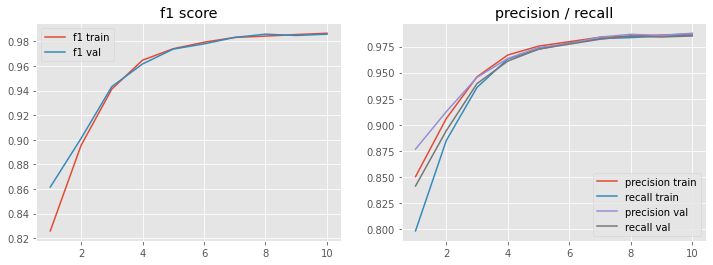

              precision    recall  f1-score   support

       anger      0.721     0.624     0.669       141
         joy      0.846     0.622     0.717       505
     neutral      0.795     0.925     0.855      1035
     sadness      0.600     0.521     0.558       121

    accuracy                          0.789      1802
   macro avg      0.741     0.673     0.700      1802
weighted avg      0.790     0.789     0.782      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7
4,all majority class,57.4,18.2
5,model_0. single utt,78.9,70.0


In [51]:
config = {'two_utt':False, 'include_speakers':False}

model_name = 'model_0. single utt'

y_pred = run_model(config)
scores_df = update_scores(scores_df, model_name, y_pred)
scores_df.head(10)


### m1. two utt


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 291s 545ms/step - loss: 0.7761 - f1: 0.7960 - P: 0.7399 - R: 0.6562 - val_loss: 0.4283 - val_f1: 0.8495 - val_P: 0.8657 - val_R: 0.8311

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 276s 515ms/step - loss: 0.3824 - f1: 0.8696 - P: 0.8838 - R: 0.8535 - val_loss: 0.3036 - val_f1: 0.8968 - val_P: 0.9078 - val_R: 0.8911

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/10
535/535 [==============================] - 276s 515ms/step - loss: 0.2358 - f1: 0.9206 - P: 0.9300 - R: 0.9123 - val_loss: 0.1711 - val_f1: 0.9421 - val_P: 0.9468 - val_R: 0.9374

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
535/535 [==============================] - 276s 515ms/step - loss: 0.1306 - f1:

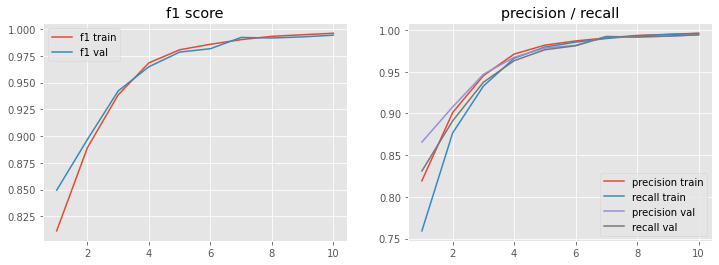

              precision    recall  f1-score   support

       anger      0.702     0.617     0.657       141
         joy      0.850     0.640     0.730       505
     neutral      0.806     0.927     0.862      1035
     sadness      0.620     0.554     0.585       121

    accuracy                          0.797      1802
   macro avg      0.744     0.684     0.708      1802
weighted avg      0.798     0.797     0.790      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7
4,all majority class,57.4,18.2
5,model_0. single utt,78.9,70.0
6,model_1. two utt,79.7,70.8


In [52]:
config = {'two_utt':True, 'include_speakers':False}

model_name = 'model_1. two utt'

y_pred = run_model(config)
scores_df = update_scores(scores_df, model_name, y_pred)
scores_df.head(10)


### m2. single utt + speaker


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 161s 302ms/step - loss: 0.6651 - f1: 0.8394 - P: 0.8194 - R: 0.7064 - val_loss: 0.3834 - val_f1: 0.8663 - val_P: 0.8871 - val_R: 0.8479

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 145s 272ms/step - loss: 0.3648 - f1: 0.8730 - P: 0.8875 - R: 0.8562 - val_loss: 0.2825 - val_f1: 0.9079 - val_P: 0.9147 - val_R: 0.8968

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/10
535/535 [==============================] - 146s 272ms/step - loss: 0.2250 - f1: 0.9264 - P: 0.9333 - R: 0.9185 - val_loss: 0.1707 - val_f1: 0.9411 - val_P: 0.9444 - val_R: 0.9395

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
535/535 [==============================] - 146s 272ms/step - loss: 0.1328 - f1:

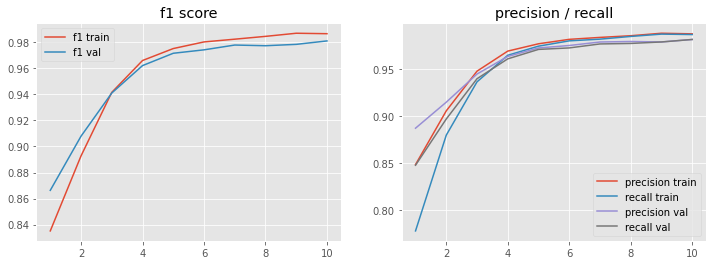

              precision    recall  f1-score   support

       anger      0.693     0.674     0.683       141
         joy      0.839     0.638     0.724       505
     neutral      0.806     0.926     0.862      1035
     sadness      0.624     0.479     0.542       121

    accuracy                          0.795      1802
   macro avg      0.741     0.679     0.703      1802
weighted avg      0.794     0.795     0.788      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7
4,all majority class,57.4,18.2
5,model_0. single utt,78.9,70.0
6,model_1. two utt,79.7,70.8
7,model_2. single utt + speaker,79.5,70.3


In [53]:
config = {'two_utt':False, 'include_speakers':True}

model_name = 'model_2. single utt + speaker'

y_pred = run_model(config)
scores_df = update_scores(scores_df, model_name, y_pred)
scores_df.head(10)


### m3. two utt + speaker


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 1/10
535/535 [==============================] - 292s 545ms/step - loss: 0.7793 - f1: 0.7991 - P: 0.7440 - R: 0.6612 - val_loss: 0.4098 - val_f1: 0.8537 - val_P: 0.8600 - val_R: 0.8405

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 2/10
535/535 [==============================] - 276s 515ms/step - loss: 0.3723 - f1: 0.8720 - P: 0.8876 - R: 0.8580 - val_loss: 0.2962 - val_f1: 0.8984 - val_P: 0.9086 - val_R: 0.8889

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 3/10
535/535 [==============================] - 276s 515ms/step - loss: 0.2152 - f1: 0.9284 - P: 0.9342 - R: 0.9234 - val_loss: 0.1610 - val_f1: 0.9505 - val_P: 0.9539 - val_R: 0.9484

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
Epoch 4/10
535/535 [==============================] - 276s 515ms/step - loss: 0.1256 - f1:

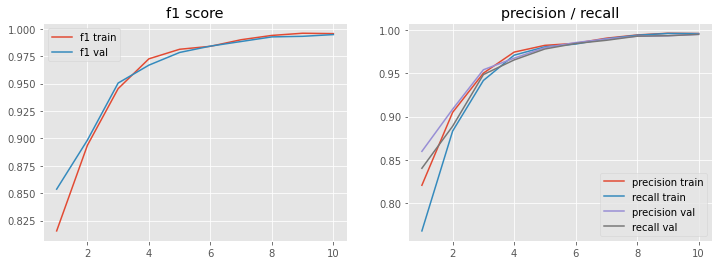

              precision    recall  f1-score   support

       anger      0.649     0.695     0.671       141
         joy      0.865     0.657     0.747       505
     neutral      0.820     0.918     0.866      1035
     sadness      0.679     0.612     0.643       121

    accuracy                          0.807      1802
   macro avg      0.753     0.720     0.732      1802
weighted avg      0.810     0.807     0.803      1802



,team/model,micro-f1,macro-f1
0,NTHU IDEA Lab --2019,81.5,73.1
1,KAKAO NLP+KU --2019,79.5,68.7
2,HSU HK --2019,79.1,69.9
3,random stratified,42.5,25.7
4,all majority class,57.4,18.2
5,model_0. single utt,78.9,70.0
6,model_1. two utt,79.7,70.8
7,model_2. single utt + speaker,79.5,70.3
8,model_3. two utt + speaker,80.7,73.2


In [54]:
config = {'two_utt':True, 'include_speakers':True}

model_name = 'model_3. two utt + speaker'

y_pred = run_model(config)
scores_df = update_scores(scores_df, model_name, y_pred)
scores_df.head(10)


### Scores

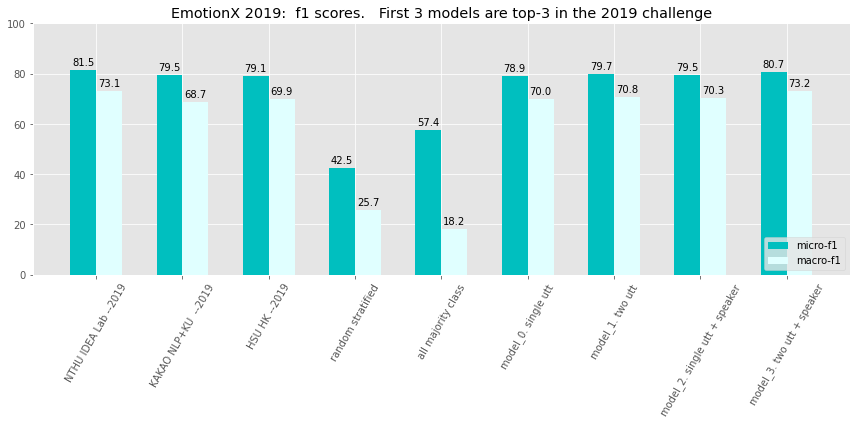

In [57]:
x = np.arange(len(scores_df))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))
micro = ax.bar(x-width/2, scores_df['micro-f1'], width, label='micro-f1', color='c')
macro = ax.bar(x+width/2, scores_df['macro-f1'], width, label='macro-f1', color='lightcyan')

ax.set_title('EmotionX 2019:  f1 scores.   First 3 models are top-3 in the 2019 challenge')
ax.set_ylim(0,100)
ax.set_xticks(x)
ax.set_xticklabels(scores_df['team/model'], rotation=60)
ax.legend(loc='lower right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}', xy=(rect.get_x()+.5*rect.get_width(), height), xytext=(0,3), 
                                     textcoords="offset points", ha='center', va='bottom')
autolabel(micro)
autolabel(macro)
fig.tight_layout()
plt.show()

### Extract BERT features

In [ ]:
model_3.layers

In [ ]:
# extract the pre-trained BERT sentence embeddings from the best-performing model
# model_3 includes the speaker one-hot vector after concatenation
model_3.layers[6]

In [ ]:
# output at layer 6 after concatenation
bert_extractor = keras.Model(inputs=model_3.input, outputs=model_3.layers[6].output)

# model_3 config. no shuffling to preserve he order for feature extraction
config = {'two_utt':True, 'include_speakers':True, 'split':1, 'shuffle':False}
f_train_ds = bert_dataset(train_df, **config)[0]
f_test_ds  = bert_dataset(test_df,  **config)[0]

# produce numpy features
f_train = bert_extractor.predict(f_train_ds)
f_test  = bert_extractor.predict(f_test_ds)

print(train_df.shape, f_train.shape)
print(test_df.shape, f_test.shape)

# save numpy features 
np.save(path+'models/train_extracted_m1', f_train, allow_pickle=True)
np.save(path+'models/test_extracted_m1', f_test, allow_pickle=True)

(18994, 6) (18994, 775)
(1802, 6) (1802, 775)
